0次のモーメント→総和

/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12510 (\N{KATAKANA LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/igor/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) 

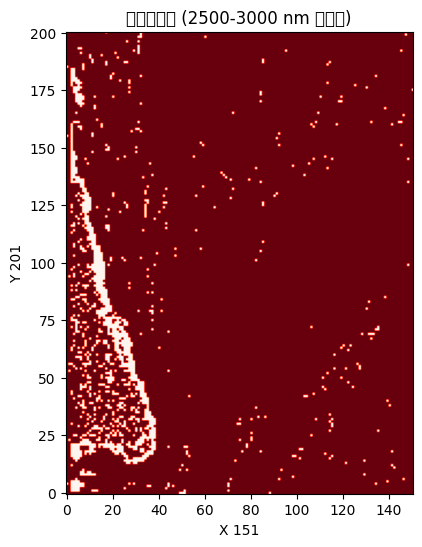

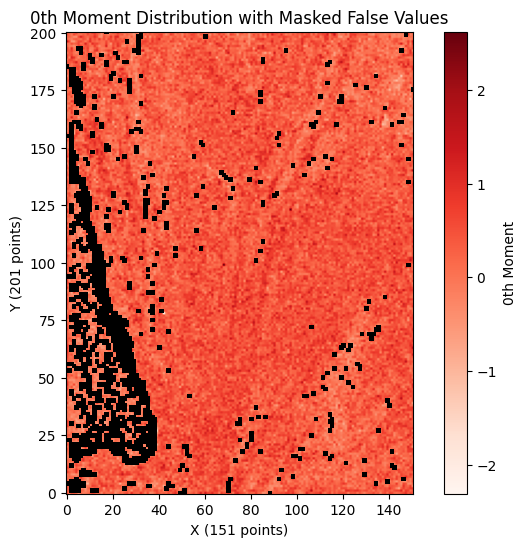

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma  # Masked array handling
from my_func.Read_ibw import read_ibw

# ベースライン補正
def subtract_baseline_between_two_wavelengths(wavelengths, spectrum, wavelength1, wavelength2):
    """
    指定した2つの波長間に直線ベースラインを引き、その直線をスペクトルから引く
    wavelengths: 波長の配列
    spectrum: スペクトルデータ
    wavelength1: 1つ目の波長 (波長の値)
    wavelength2: 2つ目の波長 (波長の値)
    """
    # スペクトルをコピーして書き込み可能にする
    spectrum_copy = spectrum.copy()

    # 指定した波長に最も近いインデックスを取得
    point1 = np.abs(wavelengths - wavelength1).argmin()
    point2 = np.abs(wavelengths - wavelength2).argmin()

    # 2点間の波長と強度を取得
    x1, x2 = wavelengths[point1], wavelengths[point2]
    y1, y2 = spectrum_copy[point1], spectrum_copy[point2]

    # 一次関数の傾きと切片を計算 (y = ax + b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1

    # 2点間の直線を引き、その直線をスペクトルから引く
    for i in range(point1, point2 + 1):
        baseline = a * wavelengths[i] + b
        spectrum_copy[i] -= baseline

    return spectrum_copy

# データの読み込み
imchi3_data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
imchi3_data = np.moveaxis(imchi3_data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# マスク処理に使う波長範囲を指定
min_wavelength = 2500  # 最小波長（nm）
max_wavelength = 3000  # 最大波長（nm）

# 指定した波長範囲に対応するインデックスを取得
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# 強度の総和を計算（指定した波長範囲のみ）
intensity_sum = np.sum(imchi3_data[:, :, :, wavelength_indices], axis=-1)  # 形状: (151, 201)

# 閾値に基づくマスクの作成
threshold = -10  # データに応じて調整
mask = intensity_sum > threshold  # 形状: (151, 201, 1)

# マスクの形状を調整（z軸を削除して2次元にする）
mask_2d = mask[:, :, 0] if mask.shape[-1] == 1 else mask

# マスク結果の表示
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d.T, cmap='Reds', origin='lower')
plt.title(f'マスク結果 ({min_wavelength}-{max_wavelength} nm の範囲)')
plt.xlabel('X 151')
plt.ylabel('Y 201')
plt.show()

# ベースライン補正範囲の指定
baseline_min_wavenumber = 1600
baseline_max_wavenumber = 1720

# 0次モーメントを保存する配列を作成 (151x201の形状に対応)
moment0_map = np.full((imchi3_data.shape[0], imchi3_data.shape[1]), np.nan)  # NaNで初期化

# ベースラインを引いた後にマスクがTrueの箇所に対してのみ0次モーメントを計算
for x in range(imchi3_data.shape[0]):
    for y in range(imchi3_data.shape[1]):
        if mask_2d[x, y]:  # マスクがTrueの箇所のみ
            spectrum = imchi3_data[x, y, 0, :].copy()  # スペクトルデータのコピーを取得
            baseline_subtracted_spectrum = subtract_baseline_between_two_wavelengths(wavelengths, spectrum, baseline_min_wavenumber, baseline_max_wavenumber)

            # 0次モーメントの計算
            range_mask = (wavelengths >= baseline_min_wavenumber) & (wavelengths <= baseline_max_wavenumber)
            spectrum_in_range = baseline_subtracted_spectrum[range_mask]
            moment0_value = np.sum(spectrum_in_range)

            # 0次モーメントをマップに反映
            moment0_map[x, y] = moment0_value

# マスクされたエリアをNaNで区別した状態で表示するためにMasked Arrayを使用
masked_moment0_map = ma.masked_invalid(moment0_map)

# ヒートマップの表示
plt.figure(figsize=(8, 6))
cmap = plt.cm.Reds  # カラーマップを設定
cmap.set_bad(color='black')  # マスクされた箇所 (NaN) を黒に設定

# カラーバー付きのヒートマップ表示
plt.imshow(masked_moment0_map.T, cmap=cmap, origin='lower')
plt.colorbar(label='0th Moment')
plt.title('0th Moment Distribution with Masked False Values')
plt.xlabel('X (151 points)')
plt.ylabel('Y (201 points)')
plt.grid(False)
plt.show()


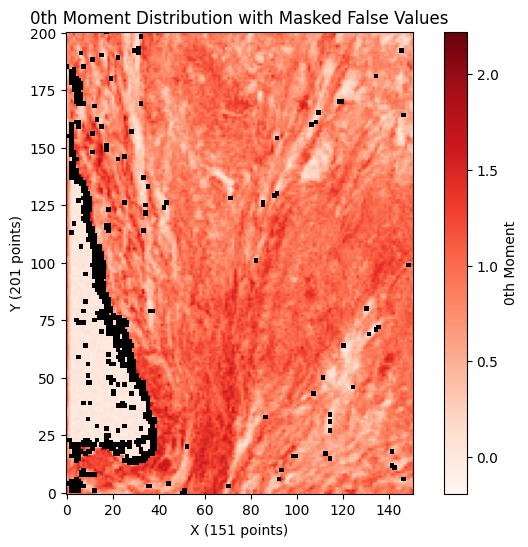

In [1]:
import numpy as np
from numpy.linalg import svd
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from my_func.Read_ibw import read_ibw
import numpy as np
import numpy.ma as ma  # Masked array handling

# SVDを全ての波長に対して行う関数
def apply_svd_to_all_wavenumbers(data, k):
    """
    データ全体に対してSVDを適用し、ノイズ除去を行う
    data: 4次元データ (x, y, z, wavelength)
    k: 上位k個の特異値を保持
    """
    reshaped_data = data[:, :, 0, :].reshape(-1, data.shape[3])  # (x*y, wavelength) の2次元に変換
    U, S, Vt = svd(reshaped_data, full_matrices=False)
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]
    S_k_matrix = np.diag(S_k)
    reconstructed_data = np.dot(U, np.dot(S_k_matrix, Vt))
    reconstructed_data = reconstructed_data.reshape(data[:, :, 0, :].shape)
    return reconstructed_data

# ベースライン補正
def subtract_baseline_between_two_wavelengths(wavelengths, spectrum, wavelength1, wavelength2):
    """
    指定した2つの波長間に直線ベースラインを引き、その直線をスペクトルから引く
    wavelengths: 波長の配列
    spectrum: スペクトルデータ
    wavelength1: 1つ目の波長 (波長の値)
    wavelength2: 2つ目の波長 (波長の値)
    """
    # スペクトルをコピーして書き込み可能にする
    spectrum_copy = spectrum.copy()

    # 指定した波長に最も近いインデックスを取得
    point1 = np.abs(wavelengths - wavelength1).argmin()
    point2 = np.abs(wavelengths - wavelength2).argmin()

    # 2点間の波長と強度を取得
    x1, x2 = wavelengths[point1], wavelengths[point2]
    y1, y2 = spectrum_copy[point1], spectrum_copy[point2]

    # 一次関数の傾きと切片を計算 (y = ax + b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1

    # 2点間の直線を引き、その直線をスペクトルから引く
    for i in range(point1, point2 + 1):
        baseline = a * wavelengths[i] + b
        spectrum_copy[i] -= baseline

    return spectrum_copy

# データの読み込み
imchi3_data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
imchi3_data = np.moveaxis(imchi3_data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

# 例: k = 10 の特異値を保持してSVDを適用
k = 80
imchi3_data = apply_svd_to_all_wavenumbers(imchi3_data, k)


wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# マスク処理に使う波長範囲を指定
min_wavelength = 2500  # 最小波長（nm）
max_wavelength = 3000  # 最大波長（nm）

# 指定した波長範囲に対応するインデックスを取得
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# 強度の総和を計算（指定した波長範囲のみ）
intensity_sum = np.sum(imchi3_data[:, :, wavelength_indices], axis=-1)  # 形状が (151, 201, wavelength) の場合


# 閾値に基づくマスクの作成
threshold = -20  # データに応じて調整
mask = intensity_sum > threshold  # 形状: (151, 201, 1)

# マスクの形状を調整（z軸を削除して2次元にする）
mask_2d = mask[:, :, 0] if mask.shape[-1] == 1 else mask

# # マスク結果の表示
# plt.figure(figsize=(8, 6))
# plt.imshow(mask_2d.T, cmap='Reds', origin='lower')
# plt.title(f'マスク結果 ({min_wavelength}-{max_wavelength} nm の範囲)')
# plt.xlabel('X 151')
# plt.ylabel('Y 201')
# plt.show()



# ベースライン補正範囲の指定
baseline_min_wavenumber = 1600
baseline_max_wavenumber = 1720

# 0次モーメントを保存する配列を作成 (151x201の形状に対応)
moment0_map = np.full((imchi3_data.shape[0], imchi3_data.shape[1]), np.nan)  # NaNで初期化

# ベースラインを引いた後にマスクがTrueの箇所に対してのみ0次モーメントを計算
for x in range(imchi3_data.shape[0]):
    for y in range(imchi3_data.shape[1]):
        if mask_2d[x, y]:  # マスクがTrueの箇所のみ
            spectrum = imchi3_data[x, y, :].copy()  # 3次元配列に対応するインデックス指定
            baseline_subtracted_spectrum = subtract_baseline_between_two_wavelengths(wavelengths, spectrum, baseline_min_wavenumber, baseline_max_wavenumber)

            # 0次モーメントの計算
            range_mask = (wavelengths >= baseline_min_wavenumber) & (wavelengths <= baseline_max_wavenumber)
            spectrum_in_range = baseline_subtracted_spectrum[range_mask]
            moment0_value = np.sum(spectrum_in_range)

            # 0次モーメントをマップに反映
            moment0_map[x, y] = moment0_value

# マスクされたエリアをNaNで区別した状態で表示するためにMasked Arrayを使用
masked_moment0_map = ma.masked_invalid(moment0_map)

# ヒートマップの表示
plt.figure(figsize=(8, 6))
cmap = plt.cm.Reds  # カラーマップを設定
cmap.set_bad(color='black')  # マスクされた箇所 (NaN) を黒に設定

# カラーバー付きのヒートマップ表示
plt.imshow(masked_moment0_map.T, cmap=cmap, origin='lower')
plt.colorbar(label='0th Moment')
plt.title('0th Moment Distribution with Masked False Values')
plt.xlabel('X (151 points)')
plt.ylabel('Y (201 points)')
plt.grid(False)


In [2]:
import os
import numpy as np
from igorwriter import IgorWave5
from datetime import datetime

# 尖度マップを .ibw ファイルに保存
def save_to_ibw(data, root_folder='result'):
    # 今日の日付を取得し、フォルダ名に使用
    today_date = datetime.now().strftime('%Y%m%d')
    
    # 保存する日時を取得し、ファイル名に組み込む
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = f"moment0th_{current_time}.ibw"
    
    # 今日の日付のフォルダを作成
    folder_path = os.path.join(root_folder, today_date)
    
    # フォルダが存在しない場合は作成
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # ファイルパスを組み立て
    file_path = os.path.join(folder_path, file_name)
    
    # IgorWave5オブジェクトを作成し、kurtosis_mapデータを保存
    wave = IgorWave5(
        data,           # 保存するデータ
        name="data",    # 波形の名前
        unicode=True,           # Unicodeサポート
        int64_support=False     # int64サポートの有無
    )

    # .ibwファイルとして保存
    wave.save(file_path)
    print(f"IBWファイルが '{file_path}' に保存されました。")

# kurtosis_mapを .ibw ファイルに保存する
save_to_ibw(masked_moment0_map)


IBWファイルが 'result/20241023/moment0th_20241023_224520.ibw' に保存されました。
